# Face Mask Detection using NVIDIA TLT 

The MIT License (MIT)

Copyright (c) 2019-2020, NVIDIA CORPORATION.

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## DetectNet_v2 with ResNet-18 example usecase

The goal of this notebook is to utilize NVIDIA TLT to train and make Face Mask detection model deploy ready.
While working on such application, this notebook will serve as an example usecase of Object Detection using DetectNet_v2 in the Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1)
    1. [Download dataset and convert in KITTI Format](#head-1-1)
    1. [Prepare tfrecords from kitti format dataset](#head-1-2)
    2. [Download pre-trained model](#head-1-3)
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
    1. [Int8 Optimization](#head-9-1)
    2. [Generate TensorRT engine](#head-9-2)
10. [Verify Deployed Model](#head-10)
    1. [Inference using TensorRT engine](#head-10-1)

![Face Mask Detection Output](https://raw.githubusercontent.com/NVIDIA-AI-IOT/face-mask-detection/master/images/face-mask-detect-output.png)

## 0. Set up env variables <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

In [1]:
# Setting up env variables for cleaner command line commands.
print("Update directory paths if needed")
%env KEY=tlt_encode
# User directory - pre-trained/unpruned/pruned/final models will be saved here
%env USER_EXPERIMENT_DIR=/workspace/face-mask-detection
# Download directory - tfrecords will be generated here
%env DATA_DOWNLOAD_DIR=/workspace/face-mask-detection         
# Spec Directory
%env SPECS_DIR=/workspace/face-mask-detection/tlt_specs   
# Number of GPUs used for training
%env NUM_GPUS=1

Update directory paths if needed
env: KEY=tlt_encode
env: USER_EXPERIMENT_DIR=/workspace/face-mask-detection
env: DATA_DOWNLOAD_DIR=/workspace/face-mask-detection
env: SPECS_DIR=/workspace/face-mask-detection/tlt_specs
env: NUM_GPUS=1


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

### A. Download dataset and convert in KITTI Format <a class="anchor" id="head-1-1"></a>

In this experiment we will be using 4 different datasets; 

1. Faces with Mask:
    - Kaggle Medical Mask Dataset [Download Link](https://www.kaggle.com/ivandanilovich/medical-masks-dataset-images-tfrecords)
    - MAFA - MAsked FAces [Download Link](https://drive.google.com/drive/folders/1nbtM1n0--iZ3VVbNGhocxbnBGhMau_OG)
2. Faces without Mask:
    - FDDB Dataset [Download Link](http://vis-www.cs.umass.edu/fddb/)
    - WiderFace Dataset [Download Link](http://shuoyang1213.me/WIDERFACE/)

- Download the data using provided links, such that all images and label files are in one folder. We expect in structure noted in GitHub repo.
- Convert dataset to KITTI format 
- Use KITTI format directory as "$DATA_DOWNLOAD_DIR"


Note: We do not use all the images from MAFA and WiderFace. Combining we will use about 6000 faces each with and without mask

### B. Prepare tf records from kitti format dataset <a class="anchor" id="head-1-2"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 

*Note: TfRecords only need to be generated once.*

In [2]:
print("TFrecords conversion spec file for kitti training")
!cat $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/face-mask-detection/train_corrected/train"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 20
  num_shards: 10 }


In [3]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!tlt-dataset-convert -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_traival

Converting Tfrecords for kitti trainval dataset
2020-11-20 04:39:53.597653: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2020-11-20 04:39:56,194 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-11-20 04:39:56,230 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 7492	Val: 1872
2020-11-20 04:39:56,230 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-11-20 04:39:56,239 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2020-11-20 04:39:56,239 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_dazel_vpraveen/715c8bafe7816f3bb6f309cd506049bb/execroot/ai_infra/bazel-out/k8-py3-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/dataio/

In [4]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval

total 12152
-rw-r--r-- 1 root root 123496 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root 124771 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root 122399 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root 121527 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root 127031 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 124068 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root 120806 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root 126927 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root 120943 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root 122625 Nov 19 19:17 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root 495769 Nov 19 1

### C. Download pre-trained model <a class="anchor" id="head-1-3"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download models with `*_detectnet_v2` in their name string. All other models expect input preprocessing with mean subtraction and input channels in BGR order. Thus, using them as pretrained weights may result in suboptimal performance. 

In [5]:
# List models available in the model registry.
!ngc registry model list nvidia/tlt_pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 82.6  | 80    | 1     | V100  | 153.8 | 153.7 | UPLOA | Apr   |
|       |       |       |       |       |       | 7 MB  | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| vgg16 | 82.2  | 80    | 1     | V100  | 113.2 | 113.2 | UPLOA | Apr   |
|       |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| squee | 65.67 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Apr   |
| zenet |       |       |       |     

In [6]:
# Create the target destination to download the model.
!mkdir -p $USER_EXPERIMENT_DIR/detectnet_v2/pretrained_resnet18/

In [7]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_detectnet_v2:resnet18 \
    --dest $USER_EXPERIMENT_DIR/detectnet_v2/pretrained_resnet18

[Transfer Error] Retrying in 10 seconds...                                                                                                             
Downloaded 82.28 MB in 33s, Download speed: 2.49 MB/s                 
----------------------------------------------------
Transfer id: tlt_pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /workspace/face-mask-detection/detectnet_v2/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18-4
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2020-11-20 04:40:33.728254
Completed at: 2020-11-20 04:41:06.776631
Duration taken: 33s
----------------------------------------------------


In [8]:
!ls -rlt $USER_EXPERIMENT_DIR/detectnet_v2/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18

total 91160
-rw------- 1 root root 93345248 Nov 19 19:36 resnet18.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [9]:
!cat $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/face-mask-detection/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/face-mask-detection/train_corrected/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "mask"
    value: "mask"
  }
  target_class_mapping {
    key: "no-mask"
    value: "no-mask"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/workspace/face-mask-detection/tfrecords/kitti_trainval/*"
    #image_directory_path: "/workspace/face-mask-detection/train_corrected/train"
  #}
}


augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    vflip_probability: 0.0
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    satur

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase, the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the same command line. Please do make sure to use the same number of GPUs when restarting the training.*

In [10]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2020-11-20 04:41:52.191406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 04:41:55.146963: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 04:41:55.175562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 04:41:55.175606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 04:41:55.175661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-20 04:41:55.176781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-11-20 04:41:55.177090: I tensorf

In [12]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 43M
-rw-r--r-- 1 root root 43M Nov 20 05:34 resnet18_detector.tlt


## 4. Evaluate the trained model <a class="anchor" id="head-4"></a>

In [13]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                           -k $KEY

Using TensorFlow backend.
2020-11-20 05:35:48.555856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 05:35:51,378 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/face-mask-detection/tlt_specs/detectnet_v2_train_resnet18_kitti.txt
2020-11-20 05:35:52.906490: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 05:35:52.956356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 05:35:52.956400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 05:35:52.956447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
20

## 5. Prune the trained model <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [14]:
# Create an output directory if it doesn't exist.
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [15]:
print("Change Threshold (-pth) value according to you experiments")

!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
           -eq union \
           -pth 0.8 \
           -k $KEY

Change Threshold (-pth) value according to you experiments
2020-11-20 05:44:40.299890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2020-11-20 05:44:44.541331: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 05:44:44.601152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 05:44:44.601194: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 05:44:44.602378: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-20 05:44:44.603368: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic lib

In [16]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 28620
-rw-r--r-- 1 root root 29305232 Nov 20 05:44 resnet18_nopool_bn_detectnet_v2_pruned.tlt


## 6. Retrain the pruned model <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model, was pruned a little too much. Please try reducing the pruning threshold, thereby reducing the pruning ratio, and use the new model to retrain.*

In [2]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/face-mask-detection/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/face-mask-detection/train_corrected/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "mask"
    value: "mask"
  }
  target_class_mapping {
    key: "no-mask"
    value: "no-mask"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/workspace/face-mask-detection/tfrecords/kitti_trainval/*"
    #image_directory_path: "/workspace/face-mask-detection/train_corrected/train"
  #}
}

augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_max: 0.200000002

In [21]:
# Retraining using the pruned model as pretrained weights 
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2020-11-20 05:56:25.355352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 05:56:28.335541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 05:56:28.360040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 05:56:28.360099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 05:56:28.360176: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-20 05:56:28.361593: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-11-20 05:56:28.362025: I tensorf

In [22]:
# Listing the newly retrained model.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 28620
-rw-r--r-- 1 root root 29305232 Nov 20 06:12 resnet18_detector_pruned.tlt


## 7. Evaluate the retrained model <a class="anchor" id="head-7"></a>

This section evaluates the pruned and retrained model, using `tlt-evaluate`.

In [23]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                           -k $KEY

Using TensorFlow backend.
2020-11-20 06:14:35.310240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 06:14:38,126 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/face-mask-detection/tlt_specs/detectnet_v2_retrain_resnet18_kitti.txt
2020-11-20 06:14:39.524098: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 06:14:39.569823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 06:14:39.569865: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 06:14:39.569910: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the `tlt-infer` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

For this you will need to create `test_images` directory containing at least 8 images with masked and no-masked faces, it can be from test data or simply face captures from your own photos. 

In [24]:
# Running inference for detection on n images
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                        -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

Using TensorFlow backend.
2020-11-20 06:30:44.473440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-20 06:30:47,338 [INFO] iva.detectnet_v2.scripts.inference: Creating output inference directory
2020-11-20 06:30:47,338 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2020-11-20 06:30:47,338 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2020-11-20 06:30:47.339983: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 06:30:47.340730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-20 06:30:47.340769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11

The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `tlt-infer` command with the path to the image.*

In [15]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows*num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[idx].imshow(img) 

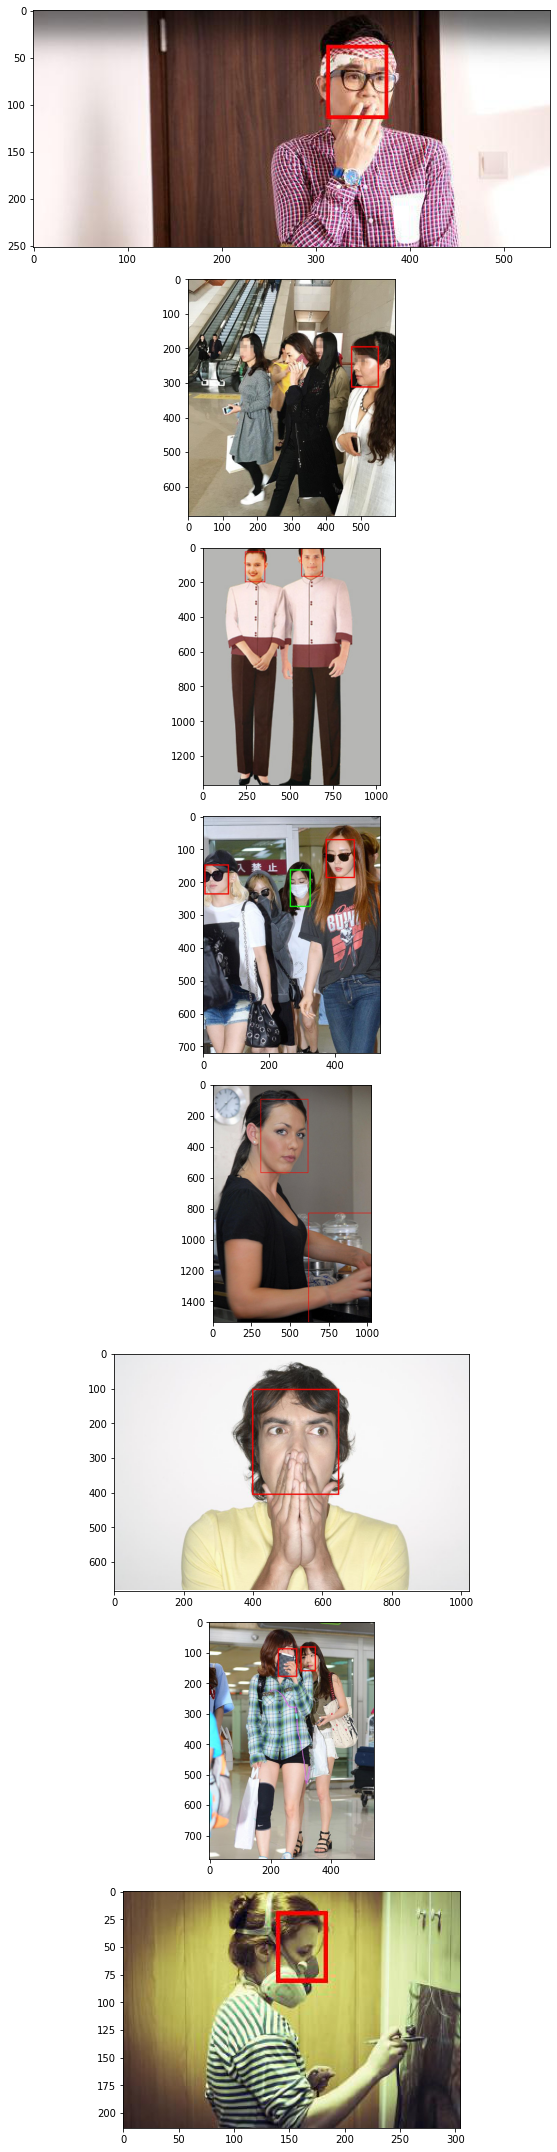

In [43]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [5]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY

Using TensorFlow backend.
2020-11-24 15:20:07.308118: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:20:10.152387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-24 15:20:10.153201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-24 15:20:10.153235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:20:10.153284: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-24 15:20:10.154300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-11-24 15:20:10.154362: I tensorf

In [6]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_final

Exported model:
------------
total 28M
-rw-r--r-- 1 root root 28M Nov 24 15:20 resnet18_detector.etlt


### A. Int8 Optimization <a class="anchor" id="head-9-1"></a>
DetectNet_v2 model supports int8 inference mode in TRT. In order to use int8 mode, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to calibrate the model. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

In [7]:
!tlt-int8-tensorfile detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                  -m 40 \
                                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

Using TensorFlow backend.
2020-11-24 15:38:14.848026: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:38:17,547 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/face-mask-detection/tlt_specs/detectnet_v2_retrain_resnet18_kitti.txt
2020-11-24 15:38:18,769 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2020-11-24 15:38:18,769 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2020-11-24 15:38:18,770 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2020-11-24 15:38:18,770 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 12, io threads: 24, compute threads: 12, buffered batches: 4
2020-11-24 15:38:18,770 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader

In [8]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY  \
            --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
            --data_type fp32 \
            --batches 20 \
            --batch_size 4 \
            --max_batch_size 4\
            --max_workspace_size 2000\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
            --verbose

Using TensorFlow backend.
2020-11-24 15:40:35.598822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:40:38.436022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-24 15:40:38.436778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:05:00.0
2020-11-24 15:40:38.436816: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:40:38.436854: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-11-24 15:40:38.437775: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-11-24 15:40:38.437835: I tensorf

### B. Generate TensorRT engine <a class="anchor" id="head-9-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [14]:
!tlt-converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
               -k $KEY \
               -o output_cov/Sigmoid,output_bbox/BiasAdd \
               -d 3,544,960 \
               -i nchw \
               -t fp32 \
               -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.engine \
               -w 1100000
               

[INFO] Some tactics do not have sufficient workspace memory to run. Increasing workspace size may increase performance, please check verbose output.
[INFO] Detected 1 inputs and 2 output network tensors.


## 10. Verify Deployed Model <a class="anchor" id="head-10"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 8](#head-8), the `tlt-infer` tool is also capable of consuming the converted `TensorRT engine` from [step 9.B](#head-9-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data, and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `tlt-export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-10-1"></a>

In [18]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                        -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

Using TensorFlow backend.
2020-11-24 15:59:26.652312: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-11-24 15:59:29,491 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2020-11-24 15:59:29,491 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2020-11-24 15:59:29,975 [INFO] iva.detectnet_v2.inferencer.trt_inferencer: Reading from engine file at: /workspace/face-mask-detection/experiment_dir_final/resnet18_detector.engine
[TensorRT] WARNING: Current optimization profile is: 0. Please ensure there are no enqueued operations pending in this context prior to switching profiles
2020-11-24 15:59:30,918 [INFO] iva.detectnet_v2.scripts.inference: Initialized model
2020-11-24 15:59:30,919 [INFO] iva.detectnet_v2.scripts.inference: Commencing inference
100%|█████████████████████████████████████████████| 2/2 [00:10<00:00,  5.38s/it]
2020-11-24 15:59:41,

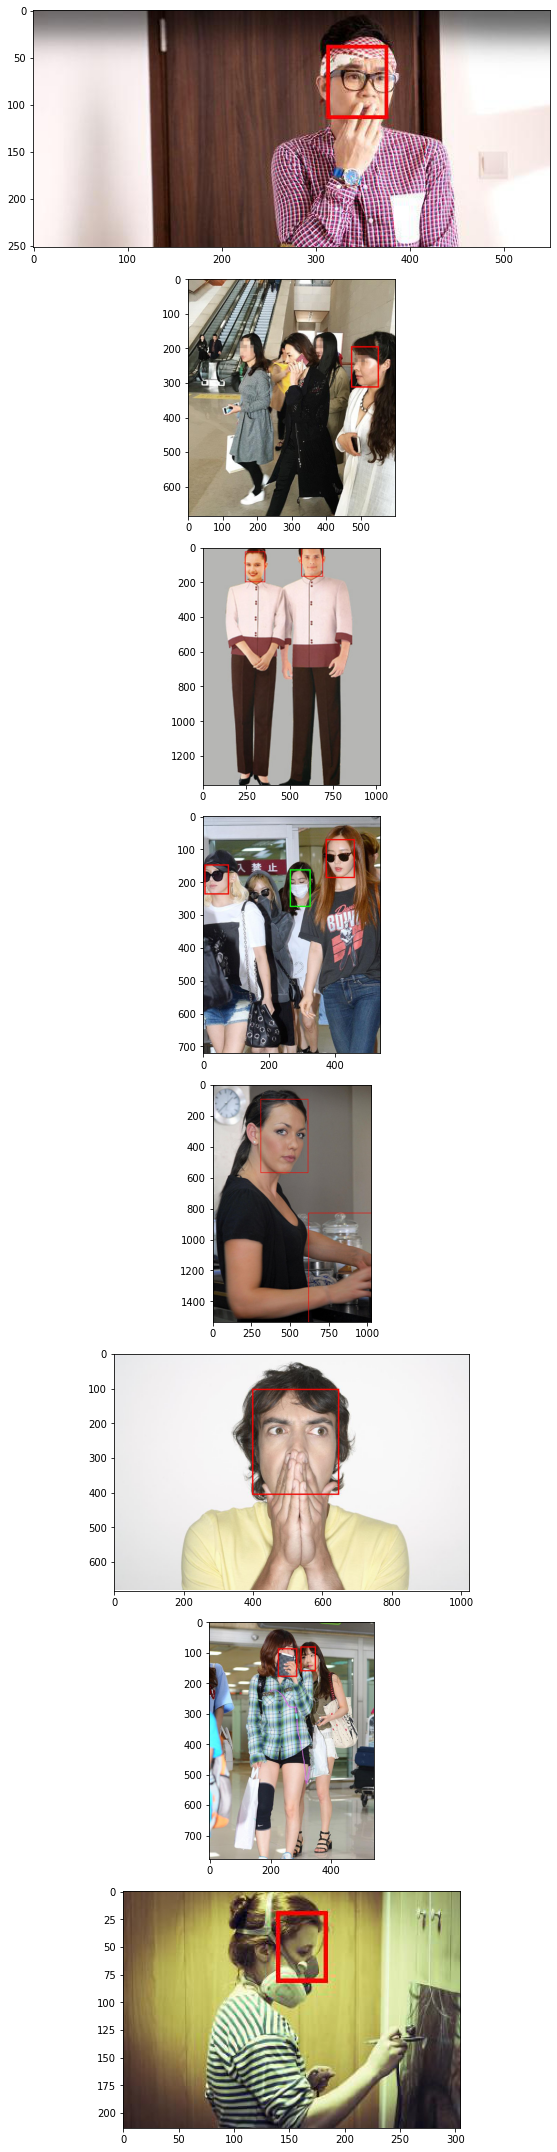

In [19]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)